In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pyvinecopulib as pv
import seaborn as sns
from scipy import stats
from py_banshee.copula_test import cvm_statistic
from scipy.interpolate import interp1d
from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.d_cal import test_distance
from py_banshee.copula_test import cvm_statistic
from py_banshee.prediction import inference,conditional_margins_hist
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Draw samples from Brute Force model
vine_model = pv.Vinecop.from_file("vinecop_model_brute_force.json")
number_of_samples = 100000
samples = vine_model.simulate(number_of_samples)

In [3]:
#%% Conditionalizing
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

def eval_ecdf(obs, x):
    interp_ecdf = interp1d(ecdf(obs)[0], ecdf(obs)[1], fill_value="extrapolate")
    return interp_ecdf(x)

def eval_inverse_ecdf(obs, x):
    ecdf_var = ecdf(obs)
    inverted_ecdf = interp1d(ecdf_var[1], ecdf_var[0], fill_value="extrapolate")
    return inverted_ecdf(x)

In [4]:
filepath = r"../Data/Clean/Obs_WL_All_Points.csv"
data = pd.read_csv(filepath, index_col=None)
data['Datetime'] = pd.to_datetime(data['Datetime'])
filter_data = data[(data['Datetime'] >= '2022-01-01') & (data['Datetime'] < '2024-01-01')]
# filter_data = filter_data.drop(columns=['WL A', 'WL B', 'WL C'])

In [5]:
filter_data

,Datetime,WL A,WL B,WL C,WL D
17158,2022-01-01 00:00:00,0.553,0.57308,0.71764,1.99912
17159,2022-01-01 01:00:00,0.526,0.55460,0.70840,1.98680
17160,2022-01-01 02:00:00,0.525,0.45604,0.66836,1.99296
17161,2022-01-01 03:00:00,0.468,0.44372,0.62832,1.97756
17162,2022-01-01 04:00:00,0.417,0.36980,0.57288,1.98680
...,...,...,...,...,...
34312,2023-12-31 16:00:00,-0.222,-0.16304,0.16324,2.81224
34313,2023-12-31 17:00:00,-0.173,-0.07988,0.22484,2.79376
34314,2023-12-31 18:00:00,-0.076,0.02484,0.29876,2.77528
34315,2023-12-31 19:00:00,0.037,0.12648,0.40964,2.76296


In [6]:
# Parameters for Gaussian noise
mu = 0  # Mean of the noise
sigma = 0.1  # Standard deviation of the noise

# Generate Gaussian noise
noise = np.random.normal(mu, sigma, filter_data['WL D'].shape[0])

# Add the noise to the time series
filter_data['WL D_with_noise'] = filter_data['WL D'] + noise

C:\Users\ferna\AppData\Local\Temp\ipykernel_15500\794676905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['WL D_with_noise'] = filter_data['WL D'] + noise


In [7]:
r2_noise = r2_score(filter_data['WL D'], filter_data['WL D_with_noise'])

print(r2_noise)

0.9927404375774785


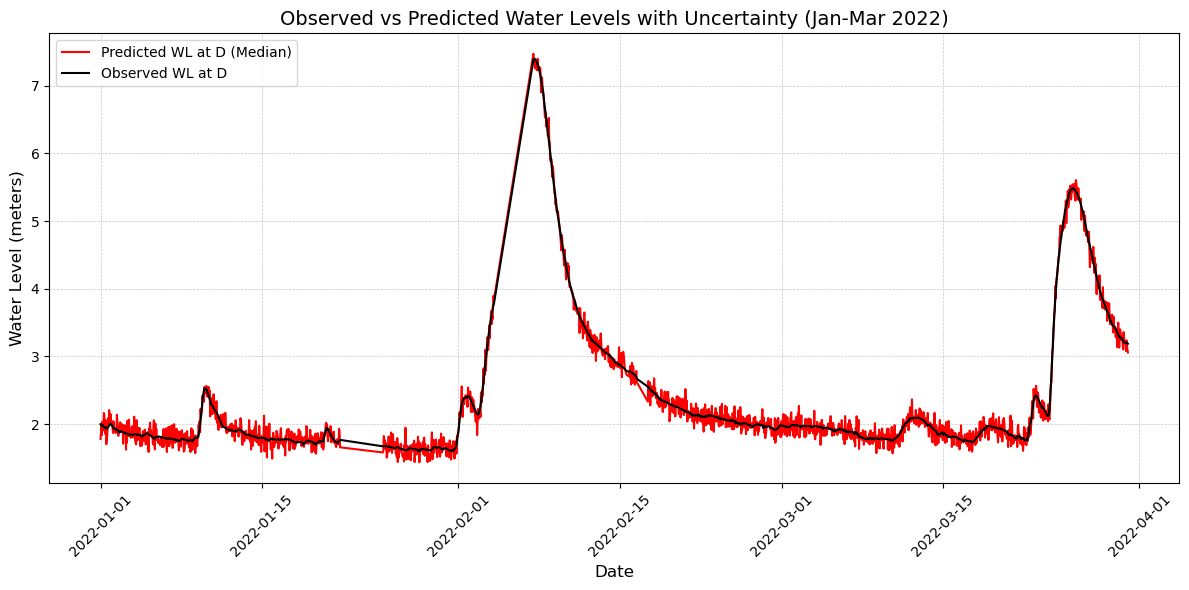

In [8]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Filter data for the first three months of 2022
filtered_three_months = filter_data[
    (filter_data['Datetime'] >= '2022-01-01') & (filter_data['Datetime'] <= '2022-03-31')
]

# Extract the required data
date = filtered_three_months['Datetime']
obs_D = filtered_three_months['WL D']  # Observed values
pred_D = filtered_three_months['WL D_with_noise']  # Predicted values with Gaussian noise
pred_D_5th = pred_D - 0.1  # Example uncertainty lower bound
pred_D_95th = pred_D + 0.1  # Example uncertainty upper bound

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot predicted water levels
ax.plot(date, pred_D, color="red", label="Predicted WL at D (Median)")

# Plot observed water levels
ax.plot(date, obs_D, color="black", label="Observed WL at D")

# Plot the uncertainty range using fill_between
# ax.fill_between(date, pred_D_5th, pred_D_95th, color="red", alpha=0.3, label="Prediction Uncertainty (5th-95th)")

# Customize x-axis
ax.set_xlabel("Date", fontsize=12)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Customize y-axis
ax.set_ylabel("Water Level (meters)", fontsize=12)

# Add a grid for better readability
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax.legend(loc="upper left", fontsize=10)

# Add a title
ax.set_title("Observed vs Predicted Water Levels with Uncertainty (Jan-Mar 2022)", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
pf_filepath = r"../Data/Clean/pf_predictions_160125.csv"
pf_data = pd.read_csv(pf_filepath, index_col=None)
pf_data['Datetime'] = pd.to_datetime(pf_data['Datetime'])
pf_data['Datetime'] = pf_data['Datetime'] - pd.Timedelta(hours=3)
pf_data.rename(columns={'PF_Predictions': 'WL A'}, inplace=True)
pf_data

,Datetime,WL A
0,2021-12-31 22:00:00,0.442152
1,2021-12-31 23:00:00,0.473496
2,2022-01-01 00:00:00,0.491756
3,2022-01-01 01:00:00,0.502227
4,2022-01-01 02:00:00,0.531171
...,...,...
17513,2023-12-31 16:00:00,-0.188372
17514,2023-12-31 17:00:00,-0.189749
17515,2023-12-31 18:00:00,-0.147026
17516,2023-12-31 19:00:00,-0.026766


In [10]:
# Align DataFrames on 'Datetime'
aligned_data = filter_data.merge(pf_data, on='Datetime', suffixes=('', '_DA'))

# Calculate R² score for 'WL A'
r2_da = r2_score(aligned_data['WL A'], aligned_data['WL A_DA'])

print(f"R² score for WL A: {r2_da:.4f}")

R² score for WL A: 0.9619


In [11]:
aligned_data

,Datetime,WL A,WL B,WL C,WL D,WL D_with_noise,WL A_DA
0,2022-01-01 00:00:00,0.553,0.57308,0.71764,1.99912,1.781906,0.491756
1,2022-01-01 01:00:00,0.526,0.55460,0.70840,1.98680,1.875637,0.502227
2,2022-01-01 02:00:00,0.525,0.45604,0.66836,1.99296,1.996339,0.531171
3,2022-01-01 03:00:00,0.468,0.44372,0.62832,1.97756,1.839543,0.480714
4,2022-01-01 04:00:00,0.417,0.36980,0.57288,1.98680,2.038177,0.471612
...,...,...,...,...,...,...,...
17154,2023-12-31 16:00:00,-0.222,-0.16304,0.16324,2.81224,2.778992,-0.188372
17155,2023-12-31 17:00:00,-0.173,-0.07988,0.22484,2.79376,2.697925,-0.189749
17156,2023-12-31 18:00:00,-0.076,0.02484,0.29876,2.77528,2.685555,-0.147026
17157,2023-12-31 19:00:00,0.037,0.12648,0.40964,2.76296,2.710172,-0.026766


In [12]:
obs_filepath = r"../Data/Clean/Obs_WL_All_Points.csv"
obs_data = pd.read_csv(obs_filepath, index_col=None)
obs_data = obs_data[(obs_data['Datetime'] >= '2020-01-01') & (obs_data['Datetime'] < '2022-01-01')]
obs_data = obs_data.drop(columns=['Datetime'])

In [13]:
# Initialize prediction as a temporary dictionary
temp_prediction = {
    'pred_WL B': [],
    'pred_WL B_5th_perc': [],
    'pred_WL B_95th_perc': [],
    'pred_WL C': [],
    'pred_WL C_5th_perc': [],
    'pred_WL C_95th_perc': []
}

# Loop through aligned_data['WL A_DA'] and aligned_data['WL D_with_noise'] using zip
for i, j in zip(aligned_data['WL A_DA'], aligned_data['WL D_with_noise']):
    # Reference column indices in samples
    cond_var1_idx = 0  # Index corresponding to 'WL A_DA' in samples
    tol1 = 0.01
    cond_val1 = i
    unity_cond1 = eval_ecdf(obs_data['WL A'], cond_val1)
    
    cond_var2_idx = 3  # Index corresponding to 'WL D_with_noise' in samples
    tol2 = 0.01
    cond_val2 = j
    unity_cond2 = eval_ecdf(obs_data['WL D'], cond_val2)

    # Filter samples based on conditions
    selection = np.array([
        row for row in samples
        if (unity_cond2 - tol2 <= row[cond_var2_idx] <= unity_cond2 + tol2) and
           (unity_cond1 - tol1 <= row[cond_var1_idx] <= unity_cond1 + tol1)
    ])
    
    # Check if selection is non-empty
    if selection.size == 0:
        # Append NaN if no rows meet the condition
        for key in temp_prediction.keys():
            temp_prediction[key].append(np.nan)
        continue  # Skip the iteration

    # Convert selection to non-unity values
    # Convert selection to non-unity values (only for 'WL B' and 'WL C')
    selection_non_unity = [
        eval_inverse_ecdf(obs_data[col_name], selection[:, idx]) 
        for idx, col_name in enumerate(['WL A', 'WL B', 'WL C', 'WL D'])
    ]
    selection_non_unity = np.array(selection_non_unity).T  # Transpose to match original shape

    # Extract columns
    column_B = selection_non_unity[:, 1]  # 'WL B' column index in samples
    column_C = selection_non_unity[:, 2]  # 'WL C' column index in samples

    # Calculate and append percentiles
    temp_prediction['pred_WL B'].append(np.percentile(column_B, 50))
    temp_prediction['pred_WL B_5th_perc'].append(np.percentile(column_B, 5))
    temp_prediction['pred_WL B_95th_perc'].append(np.percentile(column_B, 95))

    temp_prediction['pred_WL C'].append(np.percentile(column_C, 50))
    temp_prediction['pred_WL C_5th_perc'].append(np.percentile(column_C, 5))
    temp_prediction['pred_WL C_95th_perc'].append(np.percentile(column_C, 95))

# Add the new columns to aligned_data
for key, values in temp_prediction.items():
    aligned_data[key] = values


c:\Users\ferna\anaconda3\envs\multi_more\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [14]:
aligned_data

,Datetime,WL A,WL B,WL C,WL D,WL D_with_noise,WL A_DA,pred_WL B,pred_WL B_5th_perc,pred_WL B_95th_perc,pred_WL C,pred_WL C_5th_perc,pred_WL C_95th_perc
0,2022-01-01 00:00:00,0.553,0.57308,0.71764,1.99912,1.781906,0.491756,0.47760,0.407992,0.531192,0.65912,0.604296,0.733348
1,2022-01-01 01:00:00,0.526,0.55460,0.70840,1.98680,1.875637,0.502227,0.49146,0.428782,0.624208,0.68684,0.585200,0.789712
2,2022-01-01 02:00:00,0.525,0.45604,0.66836,1.99296,1.996339,0.531171,0.52996,0.415230,0.596026,0.74536,0.651882,0.846692
3,2022-01-01 03:00:00,0.468,0.44372,0.62832,1.97756,1.839543,0.480714,0.50224,0.377192,0.556756,0.66528,0.539924,0.774620
4,2022-01-01 04:00:00,0.417,0.36980,0.57288,1.98680,2.038177,0.471612,0.43448,0.377808,0.587248,0.68376,0.587048,0.784784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17154,2023-12-31 16:00:00,-0.222,-0.16304,0.16324,2.81224,2.778992,-0.188372,-0.20924,-0.333056,-0.094356,0.19712,0.063756,0.671132
17155,2023-12-31 17:00:00,-0.173,-0.07988,0.22484,2.79376,2.697925,-0.189749,-0.21540,-0.333980,-0.068330,0.18172,0.075460,0.401940
17156,2023-12-31 18:00:00,-0.076,0.02484,0.29876,2.77528,2.685555,-0.147026,-0.15842,-0.306722,-0.022746,0.24486,0.132440,0.364672
17157,2023-12-31 19:00:00,0.037,0.12648,0.40964,2.76296,2.710172,-0.026766,-0.03676,-0.107600,0.050250,0.31878,0.176330,0.399630


In [15]:
aligned_data = aligned_data.dropna()

In [16]:
aligned_data = aligned_data.reset_index(drop=True)

In [24]:
obs_B = aligned_data['WL B']
pred_B = aligned_data['pred_WL B']
r2_pred_B = r2_score(obs_B, pred_B)
rmse_pred_B = np.sqrt(mean_squared_error(obs_B, pred_B))

# R² and RMSE for C
obs_C = aligned_data['WL C']
pred_C = aligned_data['pred_WL C']
r2_pred_C = r2_score(obs_C, pred_C)
rmse_pred_C = np.sqrt(mean_squared_error(obs_C, pred_C))

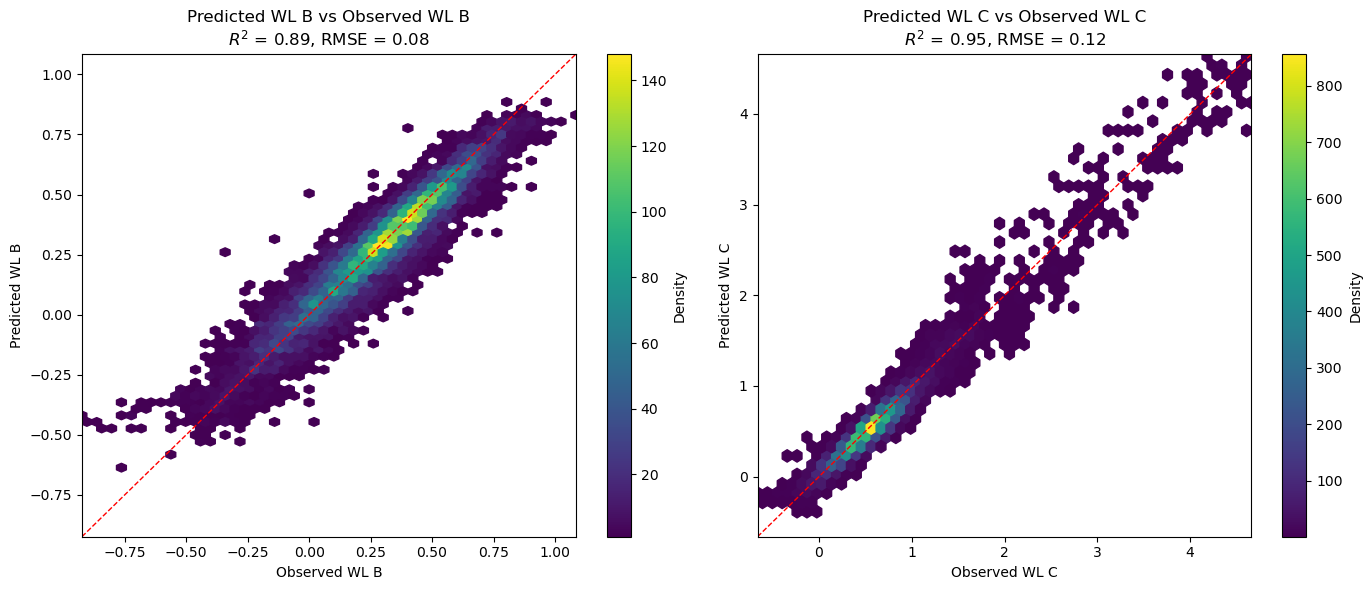

In [25]:
# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Predicted WL B vs Observed WL B
hb1 = axs[0].hexbin(obs_B, pred_B, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([obs_B.min(), obs_B.max()], [obs_B.min(), obs_B.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"Predicted WL B vs Observed WL B\n$R^2$ = {r2_score(obs_B, pred_B):.2f}, RMSE = {rmse_pred_B:.2f}")
axs[0].set_xlabel("Observed WL B")
axs[0].set_ylabel("Predicted WL B")
fig.colorbar(hb1, ax=axs[0], label='Density')

# Adjust x and y axis limits for WL B
axs[0].set_xlim([obs_B.min(), obs_B.max()])
axs[0].set_ylim([obs_B.min(), obs_B.max()])

# Plot 2: Predicted WL C vs Observed WL C
hb2 = axs[1].hexbin(obs_C, pred_C, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([obs_C.min(), obs_C.max()], [obs_C.min(), obs_C.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"Predicted WL C vs Observed WL C\n$R^2$ = {r2_score(obs_C, pred_C):.2f}, RMSE = {rmse_pred_C:.2f}")
axs[1].set_xlabel("Observed WL C")
axs[1].set_ylabel("Predicted WL C")
fig.colorbar(hb2, ax=axs[1], label='Density')

# Adjust x and y axis limits for WL C
axs[1].set_xlim([obs_C.min(), obs_C.max()])
axs[1].set_ylim([obs_C.min(), obs_C.max()])

# Adjust layout
plt.tight_layout()
plt.show()


In [19]:
snip_aligned_data = aligned_data[(aligned_data['Datetime'] >= '2023-01-01') & (aligned_data['Datetime'] < '2023-07-01')]

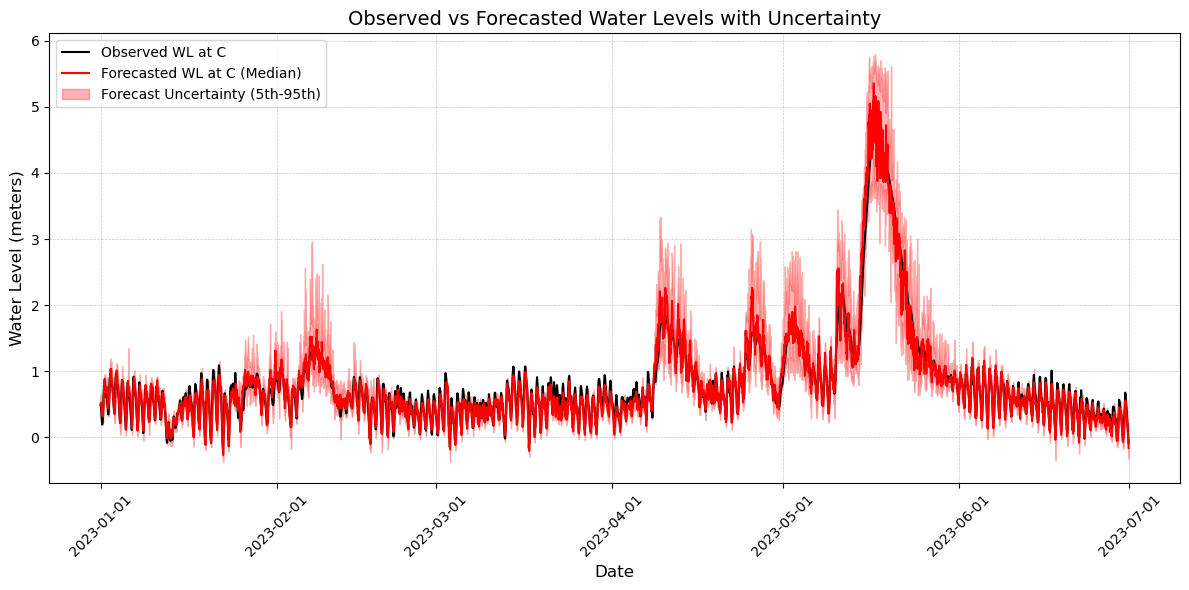

In [20]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot observed water levels
ax.plot(snip_aligned_data['Datetime'], snip_aligned_data['WL C'], color="black", label="Observed WL at C")

# Plot predicted water levels
ax.plot(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL C'], color="red", label="Forecasted WL at C (Median)")

# Plot the uncertainty range using fill_between
ax.fill_between(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL C_5th_perc'], snip_aligned_data['pred_WL C_95th_perc'], color="red", alpha=0.3, label="Forecast Uncertainty (5th-95th)")

# Customize x-axis
ax.set_xlabel("Date", fontsize=12)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Customize y-axis
ax.set_ylabel("Water Level (meters)", fontsize=12)

# Add a grid for better readability
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax.legend(loc="upper left", fontsize=10)

# Add a title
ax.set_title("Observed vs Forecasted Water Levels with Uncertainty", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

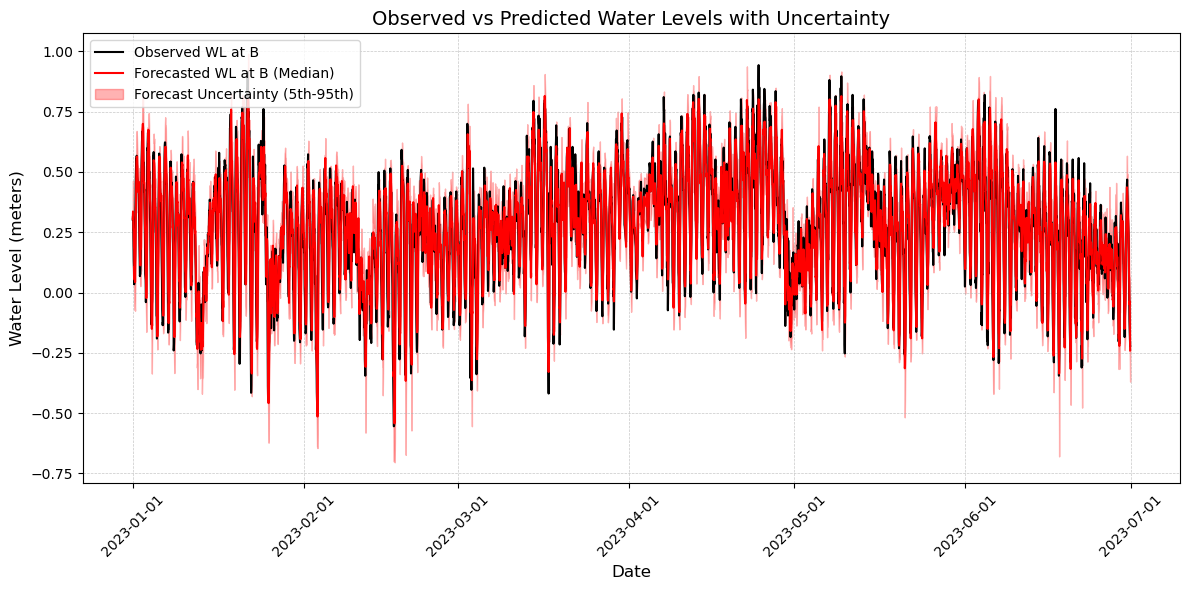

In [21]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot observed water levels
ax.plot(snip_aligned_data['Datetime'], snip_aligned_data['WL B'], color="black", label="Observed WL at B")

# Plot predicted water levels
ax.plot(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL B'], color="red", label="Forecasted WL at B (Median)")

# Plot the uncertainty range using fill_between
ax.fill_between(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL B_5th_perc'], snip_aligned_data['pred_WL B_95th_perc'], color="red", alpha=0.3, label="Forecast Uncertainty (5th-95th)")

# Customize x-axis
ax.set_xlabel("Date", fontsize=12)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Customize y-axis
ax.set_ylabel("Water Level (meters)", fontsize=12)

# Add a grid for better readability
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax.legend(loc="upper left", fontsize=10)

# Add a title
ax.set_title("Observed vs Predicted Water Levels with Uncertainty", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

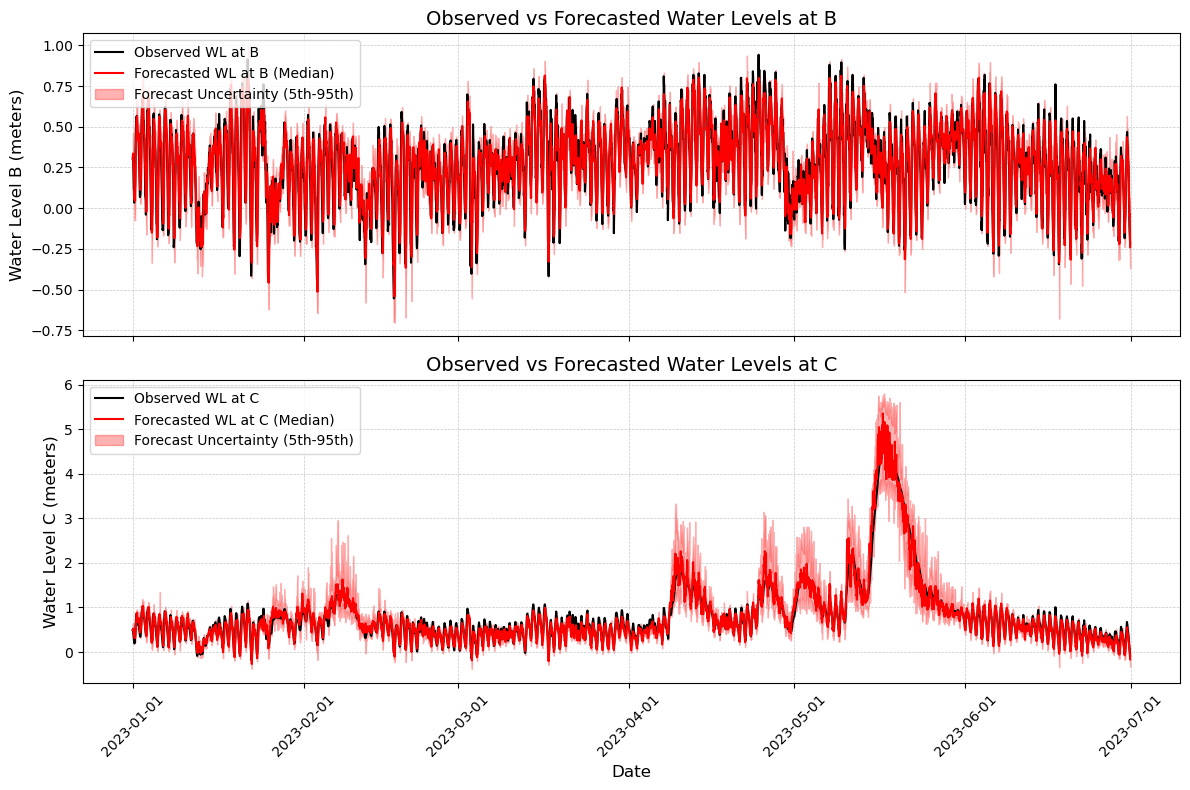

In [22]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Create the figure and axes for two subplots (up and down)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot for Water Level B
ax1.plot(snip_aligned_data['Datetime'], snip_aligned_data['WL B'], color="black", label="Observed WL at B")
ax1.plot(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL B'], color="red", label="Forecasted WL at B (Median)")
ax1.fill_between(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL B_5th_perc'], snip_aligned_data['pred_WL B_95th_perc'], color="red", alpha=0.3, label="Forecast Uncertainty (5th-95th)")
ax1.set_ylabel("Water Level B (meters)", fontsize=12)
ax1.set_title("Observed vs Forecasted Water Levels at B", fontsize=14)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot for Water Level C
ax2.plot(snip_aligned_data['Datetime'], snip_aligned_data['WL C'], color="black", label="Observed WL at C")
ax2.plot(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL C'], color="red", label="Forecasted WL at C (Median)")
ax2.fill_between(snip_aligned_data['Datetime'], snip_aligned_data['pred_WL C_5th_perc'], snip_aligned_data['pred_WL C_95th_perc'], color="red", alpha=0.3, label="Forecast Uncertainty (5th-95th)")
ax2.set_ylabel("Water Level C (meters)", fontsize=12)
ax2.set_title("Observed vs Forecasted Water Levels at C", fontsize=14)
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the shared x-axis
ax2.set_xlabel("Date", fontsize=12)
ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()
